In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

In [2]:
# path = '../input/severstal-steel-defect-detection/'
path = 'input/severstal-steel-defect-detection/'


In [3]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
# df_train['EncodedPixels'] = df_train['EncodedPixels'].apply(lambda x: str(x)) 
# df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    if rle == 'nan':
        return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

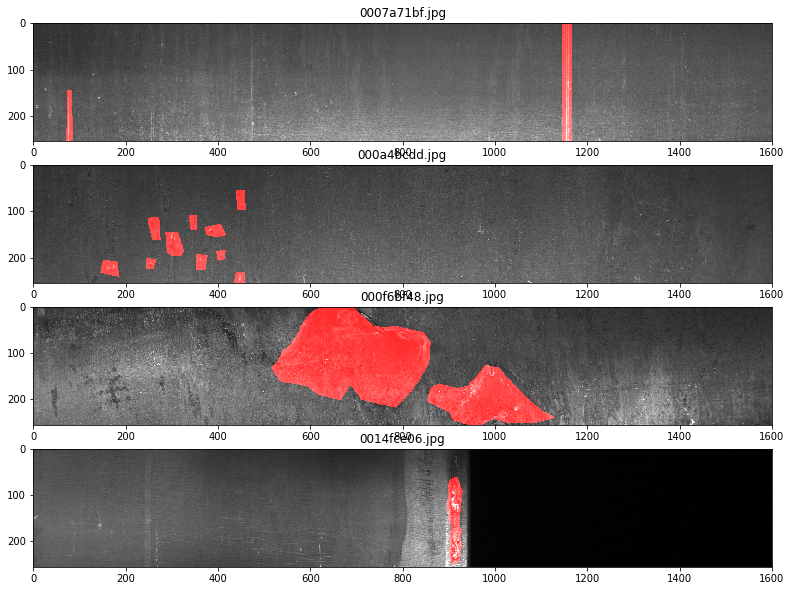

In [7]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

In [8]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            return img   

In [9]:
data_transf = transforms.Compose([
                                  transforms.Scale((256, 256)),
                                  transforms.ToTensor()])
val_size = 500
train_data = ImageData(df = df_train[val_size:], transform = data_transf)
valid_data = ImageData(df=df_train[:val_size], transform=data_transf)

C:\Users\mi\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:209: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


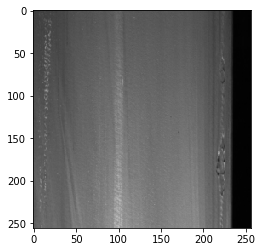

In [10]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

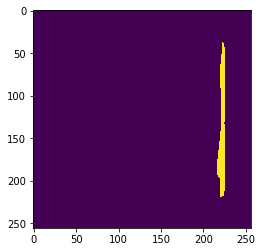

In [11]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

In [12]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [13]:
import collections
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from catalyst.data import Augmentor
from catalyst.dl import utils

bs = 8
num_workers = 4

open_fn = lambda x: {"features": x[0], "targets": x[1]}

loaders = collections.OrderedDict()

# train_loader = utils.get_loader(
#     train_data, 
#     open_fn=open_fn, 
#     batch_size=bs, 
#     num_workers=num_workers, 
#     shuffle=True)

# valid_loader = utils.get_loader(
#     valid_data, 
#     open_fn=open_fn,  
#     batch_size=bs, 
#     num_workers=num_workers, 
#     shuffle=False)
train_loader = DataLoader(dataset = train_data, batch_size=bs)
valid_loader = DataLoader(dataset = valid_data, batch_size=bs)

loaders["train"] = train_loader
loaders["valid"] = valid_loader

In [14]:
from catalyst.contrib.models.segmentation import Unet

In [15]:
import torch
import torch.nn as nn
from catalyst.dl.runner import SupervisedRunner

# experiment setup
num_epochs = 4
logdir = "./logs"

# model, criterion, optimizer
model = Unet(num_classes=1, in_channels=3, num_channels=12, num_blocks=6)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/4 * Epoch (train): 100% 825/825 [06:54<00:00,  1.74s/it, _timers/_fps=3.918, loss=0.014] 
0/4 * Epoch (valid): 100% 63/63 [00:19<00:00,  1.18it/s, _timers/_fps=3.662, loss=0.016] 
[2019-08-06 21:43:28,693] 
0/4 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.5189 | _timers/batch_time=0.3317 | _timers/data_time=0.3066 | _timers/model_time=0.0251 | loss=0.1397
0/4 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=48.3677 | _timers/batch_time=0.1993 | _timers/data_time=0.1508 | _timers/model_time=0.0484 | loss=0.0152
1/4 * Epoch (train): 100% 825/825 [06:44<00:00,  2.14it/s, _timers/_fps=24.834, loss=0.003]
1/4 * Epoch (valid): 100% 63/63 [00:14<00:00,  4.92it/s, _timers/_fps=97.825, loss=0.005]
[2019-08-06 21:50:28,799] 
1/4 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.6830 | _timers/batch_time=0.3243 | _timers/data_time=0.3069 | _timers/model_time=0.0174 | loss=0.0075
1/4 * Epoch 1 (valid): _base/lr=0

In [34]:
submit = pd.read_csv(path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '})
print(len(submit))
sub4 = submit[submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')]
print(len(sub4))
sub4.head()

7204
1801


,ImageId_ClassId,EncodedPixels
3,004f40c73.jpg_4,
7,006f39c41.jpg_4,
11,00b7fb703.jpg_4,
15,00bbcd9af.jpg_4,
19,0108ce457.jpg_4,


In [21]:
torch.save(model.state_dict(), 'model.dat')

In [22]:
model = Unet(num_classes=1, in_channels=3, num_channels=12, num_blocks=6)
model.load_state_dict(torch.load('model.dat'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [35]:
test_data = ImageData(df = submit, transform = data_transf, subset="test")
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [36]:
%%time
predict = []
model.eval()
for data in test_loader:
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy() * (-1)    
    predict.append(abs(output[0]))

Wall time: 3min 32s


In [37]:
%%time
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

Wall time: 1h 2min 15s


In [38]:
submit['EncodedPixels'] = pred_rle
submit.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


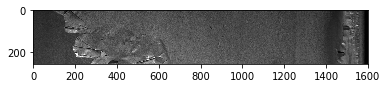

In [39]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

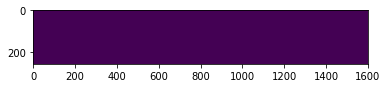

In [40]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [41]:
submit.head(10)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,
5,006f39c41.jpg_2,
6,006f39c41.jpg_3,
7,006f39c41.jpg_4,
8,00b7fb703.jpg_1,407549 2 407805 2 408061 2 408317 2 408573 2 4...
9,00b7fb703.jpg_2,407549 2 407805 2 408061 2 408317 2 408573 2 4...


In [42]:
submit.to_csv('submission.csv', index=False)